In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [ ]:
df = pd.read_csv('../../data/CREDIT_SPREAD_2010_2024.csv')

print(f"Total rows: {len(df)}")
print(f"\nFirst few rows:")
print(df.head())
print(f"\nLast few rows:")
print(df.tail())

# Check date column
df['observation_date'] = pd.to_datetime(df['observation_date'])
print(f"\nDate range: {df['observation_date'].min()} to {df['observation_date'].max()}")

# Check for COVID spike
covid = df[(df['observation_date'] >= '2020-03-01') & (df['observation_date'] <= '2020-03-31')]
if len(covid) > 0:
    print(f"\n✓ COVID data exists: Max spread = {covid['BAMLC0A4CBBB'].max():.2f}%")
else:
    print("\n✗ NO COVID DATA - Problem with file!")

# Check spread range
print(f"\nSpread statistics:")
print(f"  Min: {df['BAMLC0A4CBBB'].min():.2f}%")
print(f"  Max: {df['BAMLC0A4CBBB'].max():.2f}%")
print(f"  Mean: {df['BAMLC0A4CBBB'].mean():.2f}%")

Total rows: 3963

First few rows:
  observation_date  BAMLC0A4CBBB
0       2010-01-04          2.46
1       2010-01-05          2.42
2       2010-01-06          2.38
3       2010-01-07          2.34
4       2010-01-08          2.31

Last few rows:
     observation_date  BAMLC0A4CBBB
3958       2024-12-25           NaN
3959       2024-12-26          1.00
3960       2024-12-27          1.00
3961       2024-12-30          1.01
3962       2024-12-31          1.02

Date range: 2010-01-04 00:00:00 to 2024-12-31 00:00:00

✓ COVID data exists: Max spread = 4.88%

Spread statistics:
  Min: 0.97%
  Max: 4.88%
  Mean: 1.81%


CREDIT SPREAD FEATURE ANALYSIS - FIXED VERSION

Data retained: 3963 days from 2010-01-04 00:00:00 to 2024-12-31 00:00:00

CREDIT SPREAD STATISTICS (2010-2024)

Raw Credit Spread (BBB):
  Mean:    1.81%
  Median:  1.75%
  Std:     0.50%
  Min:     0.97% (2024-11-12)
  Max:     4.88% (2020-03-23)

Credit Regime Distribution:
    Risk-On (Normal): 2761 days ( 69.7%)
       Elevated Risk: 1193 days ( 30.1%)
       Crisis/Stress:    9 days (  0.2%)

KEY HISTORICAL EVENTS IN DATA
  2011-08-05: US Debt Downgrade              →  2.13% (Elevated Risk)
  2015-08-24: China Stock Market Crash       →  2.29% (Elevated Risk)
  2018-12-24: Christmas Eve Sell-off         →  1.97% (Risk-On (Normal))
  2020-03-23: COVID-19 Panic Bottom          →  4.88% (Crisis/Stress)
  2022-10-12: UK Pension Crisis              →  2.10% (Elevated Risk)

FEATURE CORRELATIONS

Correlation Matrix:
                          Credit_Spread_normalized  Credit_Spread_momentum  \
Credit_Spread_normalized                     1.

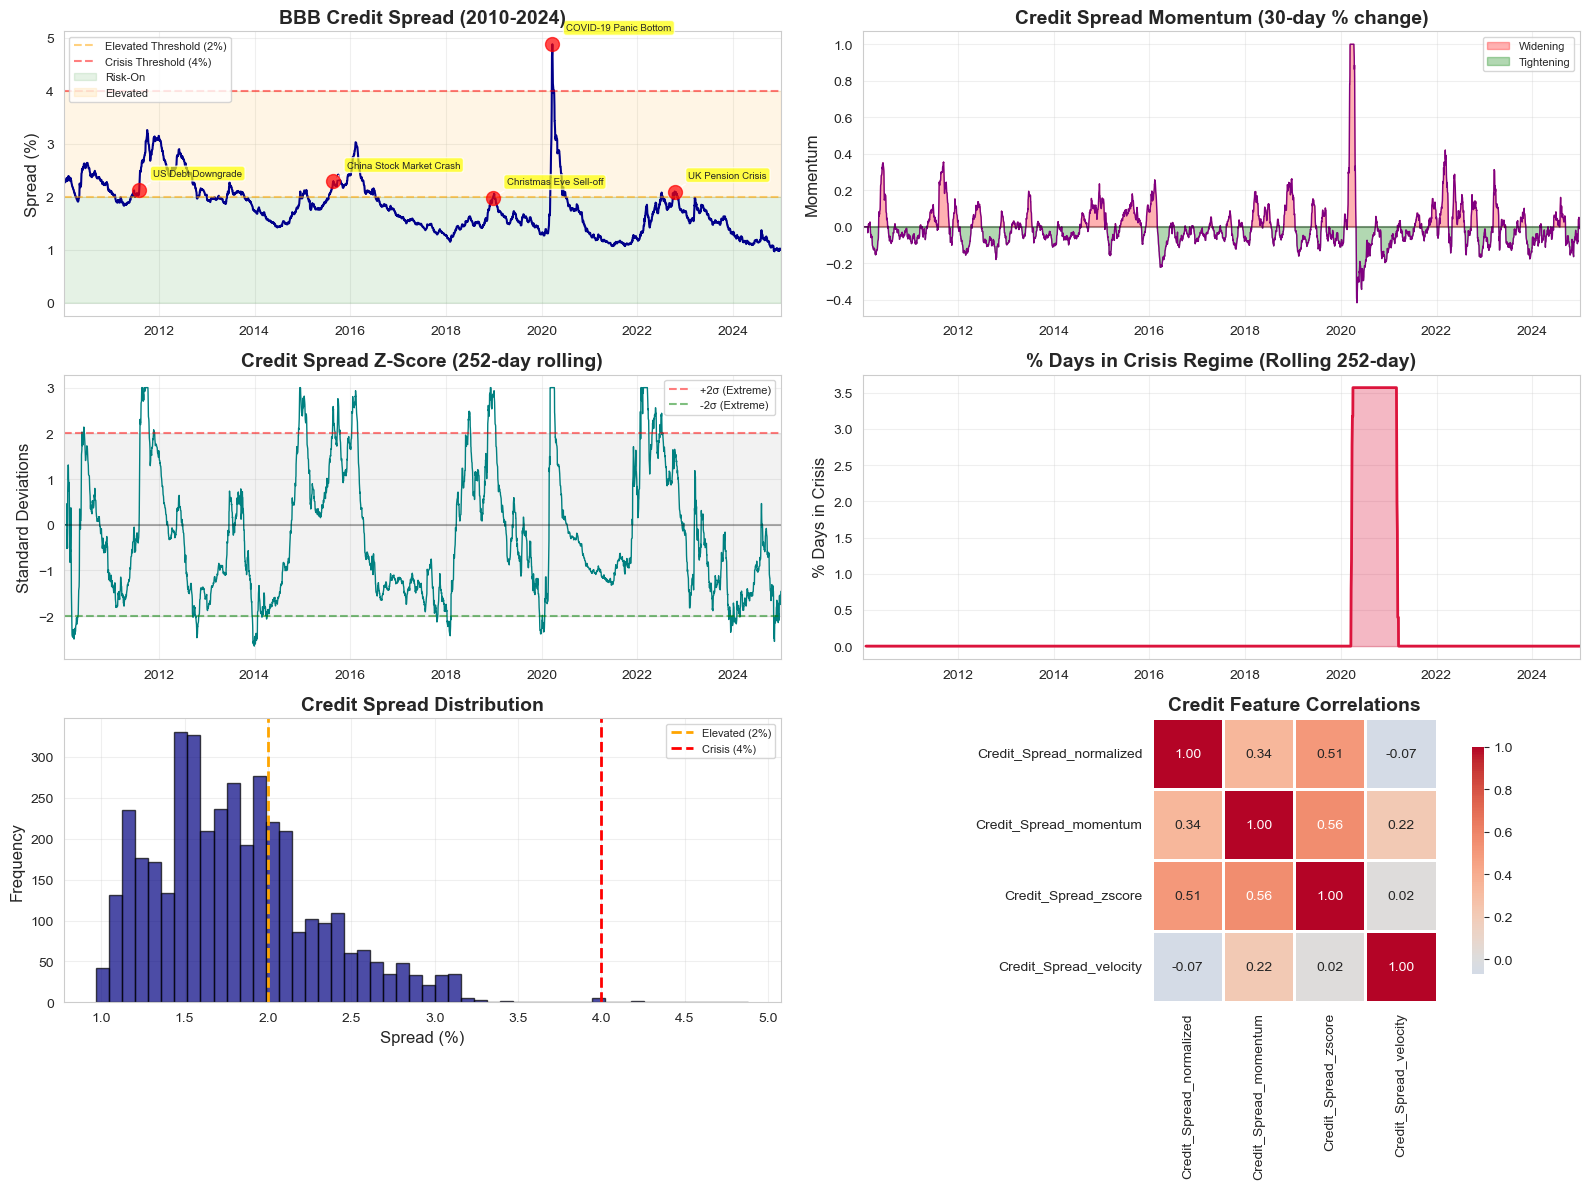


ANALYSIS COMPLETE!

Your credit spread data is perfect!
You should see:
  - COVID spike to ~4.88% in March 2020
  - 2022 bear market elevation
  - Full 15-year history displayed


In [ ]:
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 12)

print("="*70)
print("CREDIT SPREAD FEATURE ANALYSIS - FIXED VERSION")
print("="*70)

# Load credit spread data
credit_df = pd.read_csv('../../data/CREDIT_SPREAD_2010_2024.csv')
credit_df['observation_date'] = pd.to_datetime(credit_df['observation_date'])
credit_df = credit_df.set_index('observation_date')
credit_df['Credit_Spread'] = credit_df['BAMLC0A4CBBB'] / 100

# Forward fill any NaN values first (like market holidays)
credit_df['Credit_Spread'] = credit_df['Credit_Spread'].ffill()

# Feature engineering
credit_df['Credit_Spread_normalized'] = (credit_df['Credit_Spread'] - 0.02) / 0.02

def get_credit_regime(spread):
    if pd.isna(spread):
        return np.nan
    if spread < 0.02:
        return -1.0  # Risk-on
    elif spread < 0.04:
        return 0.0   # Elevated
    else:
        return 1.0   # Crisis

credit_df['Credit_Spread_regime'] = credit_df['Credit_Spread'].apply(get_credit_regime)

# Momentum with forward fill
credit_df['Credit_Spread_momentum'] = credit_df['Credit_Spread'].pct_change(30)
credit_df['Credit_Spread_momentum'] = credit_df['Credit_Spread_momentum'].fillna(0)  # Fill early values
credit_df['Credit_Spread_momentum'] = np.clip(credit_df['Credit_Spread_momentum'], -1, 1)

# Z-score with forward fill for early periods
rolling_mean = credit_df['Credit_Spread'].rolling(252, min_periods=20).mean()
rolling_std = credit_df['Credit_Spread'].rolling(252, min_periods=20).std()
credit_df['Credit_Spread_zscore'] = (credit_df['Credit_Spread'] - rolling_mean) / (rolling_std + 1e-8)
credit_df['Credit_Spread_zscore'] = credit_df['Credit_Spread_zscore'].fillna(0)
credit_df['Credit_Spread_zscore'] = np.clip(credit_df['Credit_Spread_zscore'], -3, 3)

# Velocity
credit_df['Credit_Spread_velocity'] = credit_df['Credit_Spread_momentum'].diff(5)
credit_df['Credit_Spread_velocity'] = credit_df['Credit_Spread_velocity'].fillna(0)
credit_df['Credit_Spread_velocity'] = np.clip(credit_df['Credit_Spread_velocity'], -1, 1)

# Don't dropna() - we've handled NaNs above
print(f"\nData retained: {len(credit_df)} days from {credit_df.index[0]} to {credit_df.index[-1]}")

# Statistics
print("\n" + "="*70)
print("CREDIT SPREAD STATISTICS (2010-2024)")
print("="*70)
print(f"\nRaw Credit Spread (BBB):")
print(f"  Mean:    {credit_df['Credit_Spread'].mean()*100:.2f}%")
print(f"  Median:  {credit_df['Credit_Spread'].median()*100:.2f}%")
print(f"  Std:     {credit_df['Credit_Spread'].std()*100:.2f}%")
print(f"  Min:     {credit_df['Credit_Spread'].min()*100:.2f}% ({credit_df['Credit_Spread'].idxmin().strftime('%Y-%m-%d')})")
print(f"  Max:     {credit_df['Credit_Spread'].max()*100:.2f}% ({credit_df['Credit_Spread'].idxmax().strftime('%Y-%m-%d')})")

# Regime distribution
regime_counts = credit_df['Credit_Spread_regime'].value_counts().sort_index()
print(f"\nCredit Regime Distribution:")
regime_names = {-1.0: 'Risk-On (Normal)', 0.0: 'Elevated Risk', 1.0: 'Crisis/Stress'}
for regime, count in regime_counts.items():
    if not pd.isna(regime):
        pct = count / len(credit_df) * 100
        print(f"  {regime_names[regime]:>18}: {count:4d} days ({pct:5.1f}%)")

# Key events
print(f"\n" + "="*70)
print("KEY HISTORICAL EVENTS IN DATA")
print("="*70)
events = [
    ('2011-08-05', 'US Debt Downgrade'),
    ('2015-08-24', 'China Stock Market Crash'),
    ('2018-12-24', 'Christmas Eve Sell-off'),
    ('2020-03-23', 'COVID-19 Panic Bottom'),
    ('2022-10-12', 'UK Pension Crisis')
]

for date_str, event_name in events:
    date = pd.to_datetime(date_str)
    if date in credit_df.index:
        spread = credit_df.loc[date, 'Credit_Spread'] * 100
        regime = credit_df.loc[date, 'Credit_Spread_regime']
        regime_name = regime_names.get(regime, 'Unknown')
        print(f"  {date_str}: {event_name:30s} → {spread:5.2f}% ({regime_name})")

# Feature correlations
print(f"\n" + "="*70)
print("FEATURE CORRELATIONS")
print("="*70)
feature_cols = ['Credit_Spread_normalized', 'Credit_Spread_momentum', 
                'Credit_Spread_zscore', 'Credit_Spread_velocity']
corr_matrix = credit_df[feature_cols].corr()
print("\nCorrelation Matrix:")
print(corr_matrix.round(3))

# Visualization
fig, axes = plt.subplots(3, 2, figsize=(16, 12))

# 1. Raw Credit Spread with Regime Shading
ax1 = axes[0, 0]
ax1.plot(credit_df.index, credit_df['Credit_Spread']*100, linewidth=1.5, color='darkblue')
ax1.axhline(y=2, color='orange', linestyle='--', alpha=0.5, label='Elevated Threshold (2%)')
ax1.axhline(y=4, color='red', linestyle='--', alpha=0.5, label='Crisis Threshold (4%)')
ax1.fill_between(credit_df.index, 0, 2, alpha=0.1, color='green', label='Risk-On')
ax1.fill_between(credit_df.index, 2, 4, alpha=0.1, color='orange', label='Elevated')
ax1.set_title('BBB Credit Spread (2010-2024)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Spread (%)', fontsize=12)
ax1.set_xlim(credit_df.index[0], credit_df.index[-1])  # Force full date range
ax1.legend(loc='upper left', fontsize=8)
ax1.grid(True, alpha=0.3)

# Annotate key events
for date_str, event_name in events:
    date = pd.to_datetime(date_str)
    if date in credit_df.index:
        spread = credit_df.loc[date, 'Credit_Spread'] * 100
        ax1.scatter([date], [spread], color='red', s=100, zorder=5, alpha=0.7)
        ax1.annotate(event_name, xy=(date, spread), xytext=(10, 10),
                    textcoords='offset points', fontsize=7,
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
                    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.2'))

# 2. Credit Spread Momentum
ax2 = axes[0, 1]
ax2.plot(credit_df.index, credit_df['Credit_Spread_momentum'], linewidth=1, color='purple')
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax2.fill_between(credit_df.index, credit_df['Credit_Spread_momentum'], 0, 
                  where=(credit_df['Credit_Spread_momentum']>0), alpha=0.3, color='red', label='Widening')
ax2.fill_between(credit_df.index, credit_df['Credit_Spread_momentum'], 0,
                  where=(credit_df['Credit_Spread_momentum']<=0), alpha=0.3, color='green', label='Tightening')
ax2.set_title('Credit Spread Momentum (30-day % change)', fontsize=14, fontweight='bold')
ax2.set_ylabel('Momentum', fontsize=12)
ax2.set_xlim(credit_df.index[0], credit_df.index[-1])
ax2.legend(fontsize=8)
ax2.grid(True, alpha=0.3)

# 3. Credit Spread Z-Score
ax3 = axes[1, 0]
ax3.plot(credit_df.index, credit_df['Credit_Spread_zscore'], linewidth=1, color='teal')
ax3.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax3.axhline(y=2, color='red', linestyle='--', alpha=0.5, label='+2σ (Extreme)')
ax3.axhline(y=-2, color='green', linestyle='--', alpha=0.5, label='-2σ (Extreme)')
ax3.fill_between(credit_df.index, -2, 2, alpha=0.1, color='gray')
ax3.set_title('Credit Spread Z-Score (252-day rolling)', fontsize=14, fontweight='bold')
ax3.set_ylabel('Standard Deviations', fontsize=12)
ax3.set_xlim(credit_df.index[0], credit_df.index[-1])
ax3.legend(fontsize=8)
ax3.grid(True, alpha=0.3)

# 4. Regime Distribution Over Time
ax4 = axes[1, 1]
regime_rolling = credit_df['Credit_Spread_regime'].rolling(window=252, min_periods=20).apply(
    lambda x: (x == 1.0).sum() / len(x) * 100
)
ax4.plot(credit_df.index, regime_rolling, linewidth=2, color='crimson')
ax4.fill_between(credit_df.index, 0, regime_rolling, alpha=0.3, color='crimson')
ax4.set_title('% Days in Crisis Regime (Rolling 252-day)', fontsize=14, fontweight='bold')
ax4.set_ylabel('% Days in Crisis', fontsize=12)
ax4.set_xlim(credit_df.index[0], credit_df.index[-1])
ax4.grid(True, alpha=0.3)

# 5. Feature Distribution Histogram
ax5 = axes[2, 0]
ax5.hist(credit_df['Credit_Spread']*100, bins=50, alpha=0.7, color='navy', edgecolor='black')
ax5.axvline(x=2, color='orange', linestyle='--', linewidth=2, label='Elevated (2%)')
ax5.axvline(x=4, color='red', linestyle='--', linewidth=2, label='Crisis (4%)')
ax5.set_title('Credit Spread Distribution', fontsize=14, fontweight='bold')
ax5.set_xlabel('Spread (%)', fontsize=12)
ax5.set_ylabel('Frequency', fontsize=12)
ax5.legend(fontsize=8)
ax5.grid(True, alpha=0.3)

# 6. Feature Correlation Heatmap
ax6 = axes[2, 1]
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, ax=ax6)
ax6.set_title('Credit Feature Correlations', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('credit_spread_analysis_fixed.png', dpi=300, bbox_inches='tight')
print(f"\n✓ Visualization saved to: credit_spread_analysis_fixed.png")
plt.show()